In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**6.2 Keras로 MF 구현하기**

In [5]:
import pandas as pd
import numpy as np

#train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

#필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

#DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle = True,
                                               random_state = 2021)

In [6]:
#잠재요인 수 
K = 200

#전체 평균 계산
mu = ratings_train.rating.mean()

#사용자 아이디와 영화 아이디의 최댓값 
#1을 더하는 이유 : bias term 추가 고려
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [8]:
#kreas 모델 
user = Input(shape=(1,))
item = Input(shape=(1,))

#Embedding
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) #regularizer : 규제 -> 과적합 방지
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

#bias
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

In [10]:
#dot product 실행
R = layers.dot([P_embedding,Q_embedding],axes=(2,2)) #axes = (2,2) : 두번째 축끼리(K) 연산

#dot product 실행 결과 + bias
R = layers.add([R,user_bias, item_bias])

#차원을 1차원 형태의 배열로 변경 
R = Flatten()(R) 

#모델 지정 
model = Model(inputs=[user,item],outputs=R)
model.compile(
    loss = RMSE, 
    optimizer = SGD(), 
    metrics = [RMSE]
)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 200)       188800      ['input_3[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       336600      ['input_4[0][0]']                
                                                                                              

- embedding_3 : P (200 X 944)
- embedding_4 : Q (200 X 1683)

- embedding_5, embedding_6 : bias 

In [13]:
#신경망 학습
result = model.fit(
    x = [ratings_train.user_id.values, 
         ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu, #전체 평균 빼기 
    epochs = 60,
    batch_size = 256,
    validation_data = (
        [ratings_test.user_id.values,
         ratings_test.movie_id.values],
         ratings_test.rating.values -mu
    )
)

Epoch 1/60
313/313 [==============================] - 6s 15ms/step - loss: 5.2644 - RMSE: 1.1255 - val_loss: 5.0001 - val_RMSE: 1.1161
Epoch 2/60
313/313 [==============================] - 4s 14ms/step - loss: 4.7753 - RMSE: 1.1234 - val_loss: 4.5413 - val_RMSE: 1.1142
Epoch 3/60
313/313 [==============================] - 4s 12ms/step - loss: 4.3439 - RMSE: 1.1216 - val_loss: 4.1364 - val_RMSE: 1.1124
Epoch 4/60
313/313 [==============================] - 4s 11ms/step - loss: 3.9632 - RMSE: 1.1198 - val_loss: 3.7793 - val_RMSE: 1.1108
Epoch 5/60
313/313 [==============================] - 4s 13ms/step - loss: 3.6273 - RMSE: 1.1181 - val_loss: 3.4642 - val_RMSE: 1.1093
Epoch 6/60
313/313 [==============================] - 4s 12ms/step - loss: 3.3309 - RMSE: 1.1163 - val_loss: 3.1862 - val_RMSE: 1.1079
Epoch 7/60
313/313 [==============================] - 4s 12ms/step - loss: 3.0695 - RMSE: 1.1148 - val_loss: 2.9410 - val_RMSE: 1.1066
Epoch 8/60
313/313 [==============================] - 5

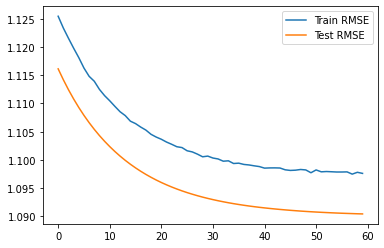

In [15]:
#plot RMSE
import matplotlib.pyplot as plt 
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()

In [16]:
#실제 적용 
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu #전체 평균 다시 더하기 

In [17]:
print(ratings_test[0:6]) #실제값

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [18]:
print(predictions) #예측값 

[[3.5548978]
 [3.4734666]
 [3.5502095]
 [3.5695748]
 [3.1889663]
 [3.5957782]]


In [19]:
#RMSE 계산 

def RMSE2(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2)) 

In [21]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred,order="C") #1차원 형태

y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0913650451838208

- 결과가 나쁜 이유 : 튜닝 부족 

#**6.3 딥러닝을 적용한 추천 시스템**

In [24]:
import pandas as pd
import numpy as np

#train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

#필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

#layer 구성에 필요한 라이브러리 불러오기 
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax

#DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle = True,
                                               random_state = 2021)

#잠재요인 수 
K = 200

#전체 평균 계산
mu = ratings_train.rating.mean()

#사용자 아이디와 영화 아이디의 최댓값 -> 보통은 unique한 값의 개수 + 1로 해야함 
#1을 더하는 이유 : bias term 추가 고려
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [28]:
#kreas 모델 
user = Input(shape=(1,))
item = Input(shape=(1,))

#Embedding
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) #regularizer : 규제 -> 과적합 방지
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

#bias
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

#앞과 뒤를 한줄로 붙이기
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

R = Dense(2048)(R) #노드가 2048개인 하나의 layer를 만든 후 R과 연결 
R = Activation('linear')(R) 

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R) #출력 layer

model = Model(inputs = [user,item],outputs=R)
model.compile(loss=RMSE,
              optimizer=SGD(), #Adamax도 가능
              metrics = [RMSE])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 200)       188800      ['input_11[0][0]']               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 200)       336600      ['input_12[0][0]']               
                                                                                            

- embedding_19 (Embedding) : 994 X 200
- embedding_20 (Embedding) : 1683 X 200

- concatenate_3 (Concatenate) : 200+200+1+1 = 402 


In [29]:
#신경망 학습
result = model.fit(
    x = [ratings_train.user_id.values, 
         ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu, #전체 평균 빼기 
    epochs = 65,
    batch_size = 512, #batch_size : 전체 train_set에서 512개씩 학습시키겠다.
    validation_data = (
        [ratings_test.user_id.values,
         ratings_test.movie_id.values],
         ratings_test.rating.values -mu
    )
)

Epoch 1/65
157/157 [==============================] - 27s 162ms/step - loss: 5.3967 - RMSE: 1.1260 - val_loss: 5.2540 - val_RMSE: 1.1172
Epoch 2/65
157/157 [==============================] - 24s 155ms/step - loss: 5.1352 - RMSE: 1.1242 - val_loss: 5.0007 - val_RMSE: 1.1156
Epoch 3/65
157/157 [==============================] - 19s 124ms/step - loss: 4.8895 - RMSE: 1.1228 - val_loss: 4.7628 - val_RMSE: 1.1141
Epoch 4/65
157/157 [==============================] - 17s 110ms/step - loss: 4.6587 - RMSE: 1.1209 - val_loss: 4.5394 - val_RMSE: 1.1125
Epoch 5/65
157/157 [==============================] - 18s 115ms/step - loss: 4.4419 - RMSE: 1.1193 - val_loss: 4.3294 - val_RMSE: 1.1110
Epoch 6/65
157/157 [==============================] - 17s 110ms/step - loss: 4.2383 - RMSE: 1.1178 - val_loss: 4.1321 - val_RMSE: 1.1093
Epoch 7/65
157/157 [==============================] - 17s 110ms/step - loss: 4.0468 - RMSE: 1.1164 - val_loss: 3.9466 - val_RMSE: 1.1074
Epoch 8/65
157/157 [=====================

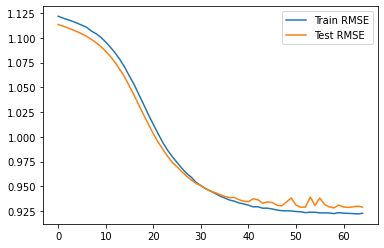

In [51]:
#plot RMSE
import matplotlib.pyplot as plt 
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()

- 뒤에 부분이 흔들리는 이유 : **과적합**

#**6.4 딥러닝 모델에 변수 추가하기**

In [37]:
import pandas as pd
import numpy as np
import os

#train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

#필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

#layer 구성에 필요한 라이브러리 불러오기 
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax

#DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle = True,
                                               random_state = 2021)

#사용자(user) 데이터 가져오기 
base_src = 'drive/MyDrive/RecoSys/Data'
u_user_src = os.path.join(base_src,'u.user')
u_cols = ["user_id","age",'sex',"occupation","zip_code"]
users = pd.read_csv(u_user_src,
                    sep = '|',
                    names = u_cols,
                    encoding='latin-1')
#사용자 ID와 직업만 남긴다.
users = users[['user_id','occupation']]

occupation = {}
def convert_occ(x):
  if x in occupation:
    return occupation[x]
  else: 
    occupation[x] = len(occupation) #ex) {선생님 : 0}
    return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation) #bias term이 없기 때문에 +1 필요 X

train_occ = pd.merge(ratings_train, users, on = 'user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on = 'user_id')['occupation']

#잠재요인 수 
K = 200

#전체 평균 계산
mu = ratings_train.rating.mean()

#사용자 아이디와 영화 아이디의 최댓값 -> 보통은 unique한 값의 개수 + 1로 해야함 
#1을 더하는 이유 : bias term 추가 고려
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [40]:
#kreas 모델 
user = Input(shape=(1,))
item = Input(shape=(1,))

#Embedding
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) #regularizer : 규제 -> 과적합 방지
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

#bias
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

#앞과 뒤를 한줄로 붙이기위해 Flatten 수행 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

#직업 변수 추가 
occ = Input(shape = (1,))
OCC_embedding = Embedding(L,3, embeddings_regularizer=l2())(occ)
OCC_layer = Flatten()(OCC_embedding) 

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, OCC_layer])

R = Dense(2048)(R) #노드가 2048개인 하나의 layer를 만든 후 R과 연결 
R = Activation('linear')(R) 

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R) #출력 layer

model = Model(inputs = [user,item, occ],outputs=R)
model.compile(loss=RMSE,
              optimizer=SGD(), #Adamax도 가능
              metrics = [RMSE])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 1, 200)       188800      ['input_25[0][0]']               
                                                                                            

- concatenate_4 (Concatenate) : 200+200+1+1+3 = 405 


In [50]:
#신경망 학습
result = model.fit(
    x = [ratings_train.user_id.values, 
         ratings_train.movie_id.values,
         train_occ.values],
    y = ratings_train.rating.values - mu, #전체 평균 빼기 
    epochs = 65,
    batch_size = 512, #batch_size : 전체 train_set에서 512개씩 학습시키겠다.
    validation_data = (
        [ratings_test.user_id.values,
         ratings_test.movie_id.values,
         test_occ.values],
         ratings_test.rating.values - mu
    )
)

Epoch 1/65
157/157 [==============================] - 22s 141ms/step - loss: 4.8898 - RMSE: 1.1217 - val_loss: 4.7631 - val_RMSE: 1.1134
Epoch 2/65
157/157 [==============================] - 18s 113ms/step - loss: 4.6589 - RMSE: 1.1199 - val_loss: 4.5395 - val_RMSE: 1.1117
Epoch 3/65
157/157 [==============================] - 22s 140ms/step - loss: 4.4420 - RMSE: 1.1183 - val_loss: 4.3295 - val_RMSE: 1.1101
Epoch 4/65
157/157 [==============================] - 22s 140ms/step - loss: 4.2383 - RMSE: 1.1166 - val_loss: 4.1319 - val_RMSE: 1.1081
Epoch 5/65
157/157 [==============================] - 17s 111ms/step - loss: 4.0465 - RMSE: 1.1147 - val_loss: 3.9462 - val_RMSE: 1.1061
Epoch 6/65
157/157 [==============================] - 17s 110ms/step - loss: 3.8662 - RMSE: 1.1127 - val_loss: 3.7715 - val_RMSE: 1.1038
Epoch 7/65
157/157 [==============================] - 18s 113ms/step - loss: 3.6966 - RMSE: 1.1106 - val_loss: 3.6071 - val_RMSE: 1.1013
Epoch 8/65
157/157 [=====================

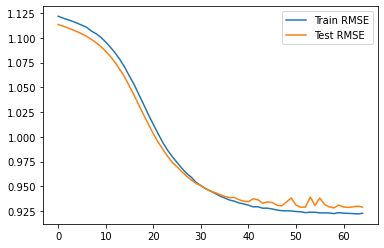

In [52]:
#plot RMSE
import matplotlib.pyplot as plt 
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()